In [13]:
import glob
import pandas as pd
import os
import glob
from datetime import datetime,timedelta

import numpy as np 

# Personnal Import 
from utilities import unormalize_tensor
from DL_utilities import DataSet
from load_data import load_subway_15_min,load_CRITER,load_netmob

## Dataset : Metro 15 minutes 2019 2020
- 24,25,26,27 Avril 2019 : Aucune données pour aucun des métro. On doit donc interdire ces séquences là dans l'entrainement et validation
- On va travailler sur les mois de Mars, Avril, Mai 2019, avec les 4 lignes de Metro A, B, C, D ainsi que la ligne de Funiculaire '326'.
- On intègrera les données NetMob dans la suite.

Init:

In [14]:
time_step_per_hour=4
H,W,D = 6,1,1
step_ahead = 1
start,end = datetime(2019,3,16),datetime(2019,6,1)

reindex = pd.date_range(start,end,freq = f'{60/time_step_per_hour}min')
print(f'Number of time-slot: {4*24*(end-start).days}')

Number of time-slot: 7392


In [15]:
try : 
    df_metro = pd.read_csv('data/Metro_15min_mar2019_mai2019.csv',index_col = 0)
    df_metro.datetime = pd.to_datetime(df_metro.datetime)

except:
    folder_path = '../../Data/keolis_data_2019-2020/'
    txt_path = "Métro 15 minutes 2019 2020.txt"

    df_metro_funi_2019_2020 = load_subway_15_min(folder_path+txt_path)
    df_metro = df_metro_funi_2019_2020[(df_metro_funi_2019_2020.datetime >= start)&(df_metro_funi_2019_2020.datetime < end)]

df_metro.head()

,datetime,Station,Code ligne,in,out
288362,2019-03-16 00:00:00,Ampère Victor Hugo,A,34,30.0
288363,2019-03-16 00:15:00,Ampère Victor Hugo,A,40,34.0
288364,2019-03-16 00:30:00,Ampère Victor Hugo,A,17,14.0
288365,2019-03-16 00:45:00,Ampère Victor Hugo,A,1,16.0
288366,2019-03-16 01:00:00,Ampère Victor Hugo,A,0,0.0


# Build Feature Vector : 
### We can: 
- select a single station, reindex and fillna. Keep 'in' and 'out' as two features
- Thanks to 'pivot_lane', we can re-organize the dataframe and keep only 'in' or only 'out' (or both).


#### Select only one station :

In [16]:
ampere = df_metro[df_metro.Station == df_metro.Station.iloc[0]]
ampere = ampere.set_index('datetime').sort_index().reindex(reindex).fillna(0)[['in','out']]
ampere.head()

,in,out
2019-03-16 00:00:00,34.0,30.0
2019-03-16 00:15:00,40.0,34.0
2019-03-16 00:30:00,17.0,14.0
2019-03-16 00:45:00,1.0,16.0
2019-03-16 01:00:00,0.0,0.0


In [17]:
dataset = DataSet(ampere,time_step_per_hour=time_step_per_hour)
norm_dataset = dataset.normalize()
(U,Utarget,df_verif) =  norm_dataset.get_feature_vect(step_ahead,H,D,W)
df_verif.head()

,t-672,t-96,t-6,t-5,t-4,t-3,t-2,t-1,t
672,2019-03-16 00:00:00,2019-03-22 00:00:00,2019-03-22 22:30:00,2019-03-22 22:45:00,2019-03-22 23:00:00,2019-03-22 23:15:00,2019-03-22 23:30:00,2019-03-22 23:45:00,2019-03-23 00:00:00
673,2019-03-16 00:15:00,2019-03-22 00:15:00,2019-03-22 22:45:00,2019-03-22 23:00:00,2019-03-22 23:15:00,2019-03-22 23:30:00,2019-03-22 23:45:00,2019-03-23 00:00:00,2019-03-23 00:15:00
674,2019-03-16 00:30:00,2019-03-22 00:30:00,2019-03-22 23:00:00,2019-03-22 23:15:00,2019-03-22 23:30:00,2019-03-22 23:45:00,2019-03-23 00:00:00,2019-03-23 00:15:00,2019-03-23 00:30:00
675,2019-03-16 00:45:00,2019-03-22 00:45:00,2019-03-22 23:15:00,2019-03-22 23:30:00,2019-03-22 23:45:00,2019-03-23 00:00:00,2019-03-23 00:15:00,2019-03-23 00:30:00,2019-03-23 00:45:00
676,2019-03-16 01:00:00,2019-03-22 01:00:00,2019-03-22 23:30:00,2019-03-22 23:45:00,2019-03-23 00:00:00,2019-03-23 00:15:00,2019-03-23 00:30:00,2019-03-23 00:45:00,2019-03-23 01:00:00


#### Select all the station :
Charpennes peut concerner métro B comme métro A. Comme on est pas en capacité de savoir quelle ligne l'usagé à choisi, on somme les deux lignes sur la même station.

In [18]:
subway_in = pd.pivot_table(df_metro,index = 'datetime',columns = 'Station',values = 'in',aggfunc = 'sum', fill_value = 0).reindex(reindex).fillna(0)
subway_out = pd.pivot_table(df_metro,index = 'datetime',columns = 'Station',values = 'out',aggfunc = 'sum', fill_value = 0).reindex(reindex).fillna(0)
subway_in.head()

Station,Ampère Victor Hugo,Bellecour,Brotteaux,Charpennes,Cordeliers,Croix Paquet,Croix-Rousse,Cuire,Cusset,Debourg,...,Part-Dieu,Perrache,Place Guichard,Place Jean Jaurès,République Villeurbanne,Sans Souci,Saxe - Gambetta,Stade de Gerland,Valmy,Vieux Lyon
2019-03-16 00:00:00,34.0,396.0,37.0,164.0,143.0,6.0,33.0,17.0,24.0,40.0,...,68.0,144.0,26.0,48.0,53.0,55.0,112.0,59.0,71.0,186.0
2019-03-16 00:15:00,40.0,298.0,56.0,164.0,139.0,3.0,46.0,7.0,20.0,46.0,...,77.0,145.0,31.0,32.0,45.0,55.0,159.0,56.0,41.0,179.0
2019-03-16 00:30:00,17.0,258.0,24.0,74.0,100.0,19.0,6.0,0.0,4.0,13.0,...,43.0,55.0,15.0,19.0,4.0,45.0,98.0,4.0,72.0,153.0
2019-03-16 00:45:00,1.0,44.0,3.0,13.0,13.0,1.0,6.0,3.0,2.0,2.0,...,6.0,5.0,3.0,4.0,0.0,13.0,17.0,4.0,3.0,14.0
2019-03-16 01:00:00,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,0.0


#### Interpolate negative values 
On peut le faire, on la montré dans Opening_data

In [19]:
subway_in = subway_in.clip(lower=-1)
subway_in = subway_in.replace(-1,np.nan)
subway_in = subway_in.interpolate(method='linear')
#subway_in = subway_in.interpolate(method='spline',order=3)

#### La valeur 10 798 de Guillotière semble suspecte

In [254]:
subway_in.max().sort_values()[-5:]

Station
Gare de Vaise                     1774.0
Saxe - Gambetta                   1788.0
Laurent Bonnevay                  2188.0
Hôtel de ville - Louis Pradel     2736.0
Guillotière                      10798.0
dtype: float64

In [21]:
s = subway_in['Guillotière']
'''
Index, Dates, Flow 
1917, 2019-04-04T23:15:00.000, 10798  Tres suspect (bordé par 61 et 75  IN)
1143, 2019-03-27T21:45:00.000, 7802   Tres suspect (bordé par 61 et 224  IN)
862, 2019-03-24T23:30:00.000, 3985   Tres suspect (bordé par 16 et 60  IN)
948, 2019-03-25T21:00:00.000, 1731   Tres suspect (bordé par 91 et 143  IN)
4176, 2019-04-28T12:00:00.000, 1275  28 Avril, les 3jours précédent sont Nulles 
'''

In [22]:
s = subway_in['Hôtel de ville - Louis Pradel']
'''
Index, Dates, Flow 
4176, 2019-04-28T12:00:00.000, 2736   28 Avril, les 3jours précédent sont Nulles 
1029, 2019-03-26T17:15:00.000, 1036  OK, Bordé par 543 et 730    -> Gros pic, comment le prévoir ? Pic ou erreur dans la donnée ? Comparer avec validation individuelles 
5925, 2019-05-16T17:15:00.000, 950  OK, Bordé par 667 et 744     -> Gros pic, comment le prévoir ? 
1697, 2019-04-02T16:15:00.000, 938  OK, Bordé par 556 et 742     -> Gros pic, comment le prévoir ? 
6793, 2019-05-25T18:15:00.000, 934  ok 
'''

'\n1917, 2019-04-04T23:15:00.000, 10798  Tres suspect (bordé par 61 et 75  IN)\n1143, 2019-03-27T21:45:00.000, 7802   Tres suspect (bordé par 61 et 224  IN)\n862, 2019-03-24T23:30:00.000, 3985   Tres suspect (bordé par 16 et 60  IN)\n948, 2019-03-25T21:00:00.000, 1731   Tres suspect (bordé par 91 et 143  IN)\n4176, 2019-04-28T12:00:00.000, 1275  28 Avril, les 3jours précédent sont Nulles \n'

### On a des gros pics. Est-ce que ce sont réellement des pics ou des erreurs dans la donnée ? 
- Les comparer avec Validation individuelles sur des données Novembre 2019 - Mars 2020 
    - Théoriquement, on peut cibler quelques stations (Guillotière, Hôtel de Ville- Louis Paredel, Charpennes) sur Novembre 2019 - Mars 2020
    - Load les données Validation, les aggréger 15 et sélectionner les mêmes période
    - Comparer les deux, voir si les plots sont cohérent.
Si on retrouve bien les mêmes choses, c'est à dire que les données sont belle et bien cohérentes : 
- Pour Mars, Avril, Mai peut-on considérer que les données sont bonne, et essayer de voir s'il y a une explication avec NetMob ?
    -  Si c'est le cas, cela justifierait l'utilisation de NetMob pour améliorer la prédiction. Il restera à savoir comment on peut design notre modèle pour améliorer cette prédiction.  
    - Comment le voir ? On peut commencer par une map dynamique (interactive) d'intensité de présence. 
### Prenons l'exemple de la gare Part-Dieu ou la gare Perrache. Leur prédiction de In est très fortement associé à l'arrivée de train. 


In [256]:
dataset = DataSet(subway_in,time_step_per_hour=time_step_per_hour)
norm_dataset = dataset.normalize()
colname2indx,indx2colname = norm_dataset.bijection_name_indx()
(U,Utarget,df_verif) =  norm_dataset.get_feature_vect(step_ahead,H,D,W)
#if len(U.shape) == 3:
#    U = U.unsqueeze(2)
#    Utarget = Utarget.unsqueeze(2)
U.shape, Utarget.shape

(torch.Size([6721, 41, 8]), torch.Size([6721, 41, 1]))

### colname2indx allow to keep track on the position of a station ('Ampere', 'Brotteaux', ...) within the Tensor

## Build Adjacency Matrix : 

# ===== Format normé des Inputs : =====
Shape : [B,N,C,L]
- B : Batch_size
- N : Nombre d'unité spatiales. N = 1 lorsqu'une seule station est traitée
- C : Nombre de Channel (Flow_in, Flow_out, Speed). C = 1 Lorsqu'un seul channel initialement
- L : Longueu de la séquence historique. Ici L = H+D+W lorsqu'il n'y a pas eu d'embedding temporel en amont.
# ==============================
## Load Models and Train 
- Essaye de capturer des dépendances spatio-temporelle. 
- Créer un modèle avec un module d'attention ou Transformer

In [257]:
import os 
import sys 
import torch.optim.SGD as SGD
import torch.nn as nn
notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

try : 
    from Ray.Ray_tune.dl_models.CNN_based_model import cnn_perso
    from Ray.Ray_tune.dl_models.RNN_based_model import rnn_perso
    from Ray.Ray_tune.dl_models.GCN_based_model import graphconv
except : 
    from Ray_tune.dl_models.CNN_based_model import cnn_perso
    from Ray_tune.dl_models.RNN_based_model import rnn_perso
    from Ray_tune.dl_models.GCN_based_model import graphconv

from DL_utilities import DictDataLoader,Trainer
from utilities import evaluate_metrics

In [260]:
train_prop = 0.6
valid_prop = 0.2
batch_size = 32

data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True)
data_loader = data_loader_obj.get_dictdataloader(batch_size)

In [262]:
# Parameters of the dataset : 
L = H+W+D 

# Hyperparameters
epochs = 10
lr = 1e-5
momentum = 0.99 # 0.9
h_dim = 64

# Model
model = cnn_perso(c_in=1, h_dim=h_dim, c_out=1, kernel_size = (2,), L=L, padding = 0)

# Optimizer, Loss, Scheduler
optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)
loss_function = nn.MSELoss()  

trainer = Trainer(model,data_loader,epochs,optimizer,loss_function,scheduler = None)
trainer.train_and_valid()

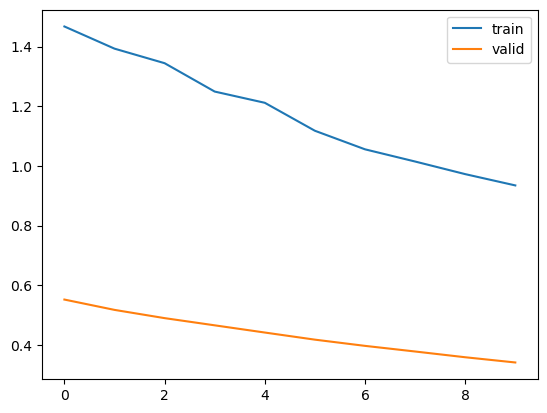

In [263]:
import matplotlib.pyplot as plt 
import numpy as np
plt.plot(np.arange(len(trainer.train_loss)),trainer.train_loss,label = 'train')
plt.plot(np.arange(len(trainer.valid_loss)),trainer.valid_loss, label = 'valid')
plt.legend()

In [265]:
(norm_Pred,norm_Y_true) = trainer.test()  # Normalized Pred and Y_true

In [266]:
df_metrics = evaluate_metrics(norm_Pred,norm_Y_true,metrics= ['mse','mae'])
df_metrics    #{'mse': tensor(0.0119), 'mae': tensor(0.0778)}  avec les données non interpolées

{'mse': tensor(0.0129), 'mae': tensor(0.0819)}

In [269]:
Pred = unormalize_tensor(norm_Pred,dataset.mini,dataset.maxi)
Y_true = unormalize_tensor(norm_Y_true,dataset.mini,dataset.maxi)

df_metrics = evaluate_metrics(Pred,Y_true,metrics= ['mse','mae'])
df_metrics    # {'mse': tensor(31837.8555), 'mae': tensor(95.1038)}  avec les données non interpolées

{'mse': tensor(33629.1914), 'mae': tensor(99.0744)}

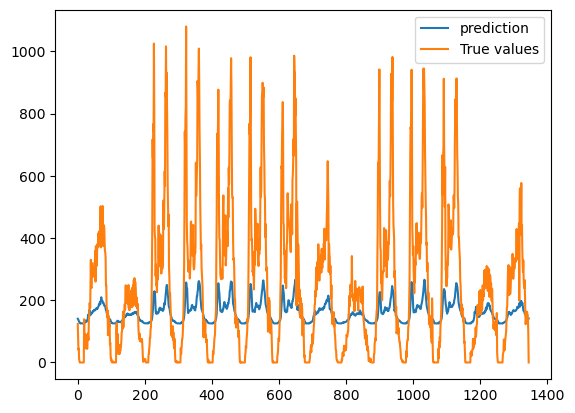

In [270]:
charpennes_idx = colname2indx['Charpennes']

charpennes_pred,charpennes_true = Pred[:,charpennes_idx,0],Y_true[:,charpennes_idx,0]

plt.plot(np.arange(len(charpennes_pred)),charpennes_pred,label = 'prediction')
plt.plot(np.arange(len(charpennes_true)),charpennes_true, label = 'True values')
plt.legend()

# Effet de model.eval() et model.train() sur le Dropout

In [171]:
drop = nn.Dropout()
x = torch.ones(1, 10)

# Train mode (default after construction)
drop.train()
print(drop(x))

# Eval mode
drop.eval()
print(drop(x))

tensor([[2., 0., 2., 0., 2., 2., 0., 2., 0., 0.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


## Convolution 1D ou 2D : 

Supposons qu'on a un Tensor 4D $[B,N,C,L]$ 
Où B est la taille du batch, N le nombre d'unité spatiales, C le nombre de Channels (Flow_in,Flow_out, Speed), et L la longueur de la séquence (historical length).

On veut passer une convolution le long de la séquence, **uniquement** et créer des channels supplémentaire : 

In [114]:
B =  32
N = 41
C = 2
L = 16
h_dim = 64

x = torch.randn(B,N,C,L)
print(f'Init shape of x: {x.shape}')
x = x.reshape(B*N*C,1,L)
conv = nn.Conv1d(1, h_dim, kernel_size=(2,),padding=0)
x = conv(x)
x = x.reshape(B,N,C,h_dim,-1)
print(f'Shape of x after passing through 1d conv on the last dim: {x.shape}')


Init shape of x: torch.Size([32, 41, 2, 16])
Shape of x after passing through 1d conv on the last dim: torch.Size([32, 41, 2, 64, 15])


# On regarde comment on veut intégrer les données et ce qu'on veut capturer :
- En faisant un unsqueeze(2) et un reshape, on fait la convolution 1d sur l'historique de la demande.
- Comment faire en sorte de capturer les dépendance entre les stations ? 
    - Convolution entre-elles 
    - FC layer à la fin de convolution en série pour capturer les informations temporelles interessante
- Comparer avec LSTM 

In [45]:
import torch.nn as nn

x_b = U[:32]
x_b = x_b.unsqueeze(2)
B,N,C_in,L = x_b.shape
h_dim = 64
kernel_size = (2,)

x_b = x_b.reshape(-1,C_in,L)

conv1d = nn.Conv1d(in_channels = C_in, out_channels = h_dim, kernel_size=kernel_size,padding=0)
conv_x_b = conv1d(x_b).reshape(B,N,h_dim,-1)  
conv_x_b.shape


torch.Size([32, 41, 64, 7])

## Ajout des données NetMob

## Concentration sur les événements atypiques / anomalies